In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
base_path = "data"
train = pd.read_csv(f'{base_path}/train.csv.zip', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv.zip', index_col="ID")
submission = pd.read_csv(f'{base_path}/sample_submission.csv.zip', index_col="ID")

In [3]:
cat_col = train.select_dtypes(include="object").columns
train[cat_col] = train[cat_col].astype("category")
test[cat_col] = test[cat_col].astype("category")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 8417
Columns: 377 entries, y to X385
dtypes: category(8), float64(1), int64(368)
memory usage: 11.9 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 1 to 8416
Columns: 376 entries, X0 to X385
dtypes: category(8), int64(368)
memory usage: 11.9 MB


In [6]:
train["y"].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

## XGBoost
* xgboost는 GBT에서 병렬 학습을 지원하여 학습 속도가 빨라진 모델입니다.
* 기본 GBT에 비해 더 효율적이고, 다양한 종류의 데이터에 대응할 수 있으며 이식성이 높습니다.


### XGBoost Parameter

https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

In [7]:
X, y = train.drop(columns="y"), train["y"]
X.shape, y.shape

((4209, 376), (4209,))

In [8]:
# train_test_split을 이용해 X, y 값을 X_train, X_valid, y_train, y_valid 으로 나눠줍니다.
# Hold-out-valiation을 위해 train, valid 세트로 나누기
# test_size=0.1 => 이름은 test지만 train으로 나눠주었기 때문에 valid 사이즈를 지정한 것입니다.
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3788, 376), (421, 376), (3788,), (421,))

In [9]:
# xgboost는 gradient boosting tree(GBT)의 병렬 학습을 구현한 라이브러리입니다.
import xgboost as xgb

xgb.__version__

'1.7.4'

* https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

* n_estimators: 생성할 트리의 개수를 지정합니다. 이 값이 클수록 모델의 복잡도가 증가하며, 오버피팅(overfitting) 가능성이 높아집니다.
    * learning_rate가 낮을 땐, n_estimators를 높여야 과적합이 방지됨
    * 너무 작으면 underfitting이 되고 이는 낮은 정확성의 prediction이 되는반면 
    * 너무 크면 overfitting이 되고 training 에는 정확한 prediction을 보이지만 test 에서는 정확성이 낮은 prediction을 가짐
* learning_rate: 각 트리의 예측값에 대한 가중치를 지정하는 값입니다. 이 값이 작을수록 모델의 학습 속도가 느려지지만, 더욱 정확한 예측을 수행할 수 있습니다.
* max_depth: 생성할 트리의 최대 깊이를 지정합니다. 이 값이 크면 모델이 복잡해지며, 오버피팅 가능성이 높아집니다.
* subsample: 각 트리에서 사용할 학습 데이터의 비율을 지정합니다. 이 값이 작을수록 모델의 일반화 능력이 향상됩니다.
* colsample_bytree: 각 트리에서 사용할 피처의 비율을 지정합니다. 이 값이 작을수록 모델의 일반화 능력이 향상됩니다.
* gamma: 각 노드에서 추가적으로 분할하기 위한 최소 손실 감소값을 지정합니다. 이 값이 클수록 모델이 보수적으로 학습하며, 오버피팅 가능성이 줄어듭니다.
* reg_alpha: L1 정규화(regularization) 계수를 지정합니다. 이 값이 클수록 모델이 보수적으로 학습하며, 오버피팅 가능성이 줄어듭니다.
* reg_lambda: L2 정규화(regularization) 계수를 지정합니다. 이 값이 클수록 모델이 보수적으로 학습하며, 오버피팅 가능성이 줄어듭니다.
* objective: 손실함수를 지정합니다. 이 값은 주어진 문제 유형에 따라 다르게 지정됩니다.
    * 회귀 문제의 경우 'reg:squarederror'
    * 이진 분류 문제의 경우 'binary:logistic'
    * 다중 분류 문제의 경우 'multi:softmax'
* booster: 사용할 부스팅 알고리즘을 지정합니다. 
    * 'gbtree'는 트리 기반 부스팅 알고리즘
    * 'gblinear'는 선형 부스팅 알고리즘
    * 'dart'는 Dropout을 이용한 알고리즘
* scale_pos_weight: 이진 분류 문제에서 양성 클래스의 비율이 음성 클래스보다 작을 때 사용합니다. 
    * 음성 클래스의 수 / 양성 클래스의 수 로 계산
* early_stopping_rounds: 조기 종료(early stopping)를 위한 설정입니다. 이 값은 지정된 수 만큼 검증 세트의 손실이 감소하지 않으면 학습을 종료합니다.
* tree_method: 트리 학습 알고리즘을 지정합니다. 
    * 'auto'는 자동 선택
    * 'exact'는 완전하게 성장하는 트리
    * 'approx'는 근사치 기반 알고리즘 
    * 'hist'는 히스토그램 기반 알고리즘 
    * 'gpu_hist'는 GPU 기반 히스토그램 기반 알고리즘
* gpu_id: GPU 사용을 위한 설정입니다. 이 값을 -1로 지정하면 자동 선택됩니다.
* verbosity: 출력 메시지의 상세도를 지정합니다. 0은 출력을 하지 않습니다. 값이 클수록 더 자세한 출력을 보여줍니다.

* eval_metric:
    * rmse: root mean square error
    * mae: mean absolute error
    * logloss: negative log-likelihood
    * error: Binary classification error rate (0.5 threshold)
    * merror: Multiclass classification error rate
    * mlogloss: Multiclass logloss
    * auc: Area under the curve
    * map (mean average precision)


In [10]:
categorical_feature = X_train.select_dtypes(include="category").columns.tolist()
categorical_feature

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

In [11]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=1000, 
                             max_depth=3,
                             random_state=42, 
                             n_jobs=-1, 
                             tree_method="hist", 
                             enable_categorical=True)
model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [12]:
es = xgb.callback.EarlyStopping(
    rounds=5,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name=["r2"],
)

model_xgb.set_params(callbacks=[xgb.callback.EarlyStopping(rounds=20, save_best=True)])

model_xgb.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)])

[0]	validation_0-rmse:71.12762
[1]	validation_0-rmse:50.11520
[2]	validation_0-rmse:35.50581
[3]	validation_0-rmse:25.43677
[4]	validation_0-rmse:18.57799
[5]	validation_0-rmse:14.06008
[6]	validation_0-rmse:11.16728
[7]	validation_0-rmse:9.44406
[8]	validation_0-rmse:8.46370
[9]	validation_0-rmse:7.96020
[10]	validation_0-rmse:7.69610
[11]	validation_0-rmse:7.55750
[12]	validation_0-rmse:7.47873
[13]	validation_0-rmse:7.43875
[14]	validation_0-rmse:7.42556
[15]	validation_0-rmse:7.41625
[16]	validation_0-rmse:7.39490
[17]	validation_0-rmse:7.39485
[18]	validation_0-rmse:7.42124
[19]	validation_0-rmse:7.41981
[20]	validation_0-rmse:7.41790
[21]	validation_0-rmse:7.42622
[22]	validation_0-rmse:7.42493
[23]	validation_0-rmse:7.44729
[24]	validation_0-rmse:7.45119
[25]	validation_0-rmse:7.44710
[26]	validation_0-rmse:7.44162
[27]	validation_0-rmse:7.44427
[28]	validation_0-rmse:7.44560
[29]	validation_0-rmse:7.43674
[30]	validation_0-rmse:7.46350
[31]	validation_0-rmse:7.48454
[32]	valida

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x12e183c40>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

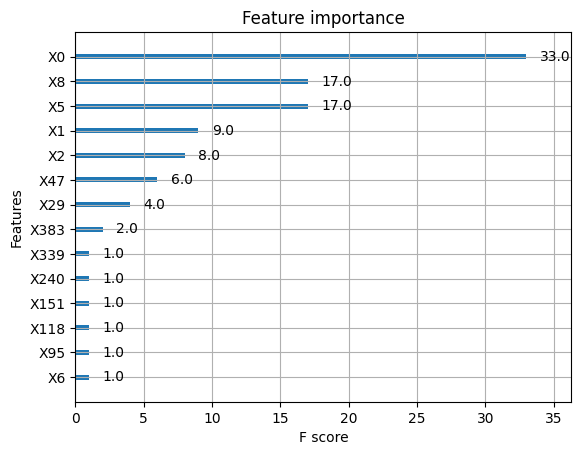

In [13]:
xgb.plot_importance(model_xgb)

In [14]:
xgb_score = model_xgb.score(X_valid, y_valid)
xgb_score

0.6191137398279257

In [15]:
y_pred_xgb = model_xgb.predict(test)
y_pred_xgb[:5]

array([ 77.99995, 107.734  ,  84.73155,  80.69754,  95.35103],
      dtype=float32)

In [16]:
submission["y"] = y_pred_xgb

https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/submissions

In [17]:
file_name = f'{base_path}/sub_xgb_{xgb_score:.5f}.csv'
file_name

'data/sub_xgb_0.61911.csv'

In [18]:
submission.to_csv(file_name)
pd.read_csv(file_name, index_col="ID").head(2)

,y
ID,
1,77.99995
2,107.73400
